init

In [16]:
import pyepsg
import snappy
from snappy import HashMap
import gc   
from snappy import GPF
jpy = snappy.jpy
from snappy import ProductIO, File
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cartopy.crs as ccrs
import numpy as np
import rasterio
from rasterio.windows import Window
from rasterio.plot import show
from rasterio.enums import Resampling

In [ ]:
#file type
File = jpy.get_type('java.io.File')

#product to be used
archi=File('C:/Users/Massimo/Documents/SchoolFolder/ThirdYear/Thesis/SentinelData/2021/extra/S3B_SL_2_LST____20210616T094035_20210616T094335_20210617T190722_0179_053_307_2340_LN2_O_NT_004.SEN3')

Reading Product

In [ ]:
archi=File('C:/Users/Massimo/Documents/SchoolFolder/ThirdYear/Thesis/SentinelData/2021/extra/S3B_SL_2_LST____20210616T094035_20210616T094335_20210617T190722_0179_053_307_2340_LN2_O_NT_004.SEN3')
product = ProductIO.readProduct(archi)
reader = snappy.ProductIO.getProductReader('SEN3')

In [ ]:
#listing all bands
list(product.getBandNames())

['LST_uncertainty_locATM',
 'LST_uncertainty_locGEO',
 'LST_uncertainty_locSF',
 'LST_uncertainty_locT',
 'LST_uncertainty_random',
 'LST_uncertainty_sys',
 'NDVI',
 'TCWV',
 'biome',
 'fraction',
 'LST',
 'LST_uncertainty',
 'exception',
 'x_in',
 'y_in',
 'bayes_in',
 'cloud_in',
 'confidence_in',
 'pointing_in',
 'probability_cloud_dual_in',
 'probability_cloud_single_in',
 'elevation_in',
 'latitude_in',
 'longitude_in',
 'detector_in',
 'pixel_in',
 'scan_in']

In [ ]:
band = product.getBand('LST') # Assign Band to a variable
w = product.getSceneRasterWidth() # Get Band Width
h = product.getSceneRasterHeight() # Get Band Height

Creating image from product for reference

In [ ]:
# Create an empty array
band_data = np.zeros(w * h, np.float32)
# Populate array with pixel value
band.readPixels(0, 0, w, h, band_data) 
# Reshape
band_data.shape = h, w
# Plot the band  
plt.figure(figsize=(18,10))

<Figure size 1296x720 with 0 Axes>

<Figure size 1296x720 with 0 Axes>

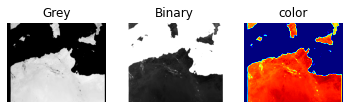

In [ ]:
##Heatmap colours
color = cm.jet
color.set_bad('white')
#plt.imshow(band_data, cmap = color)

#plt.show()

plt.subplot(131)
plt.imshow(band_data, cmap='gray'), plt.title('Grey')
plt.axis('off')
plt.subplot(132)
plt.imshow(band_data, cmap = plt.cm.binary), plt.title('Binary')
plt.axis('off')
plt.subplot(133)
plt.imshow(band_data, cmap = color), plt.title('color')
plt.axis('off')
plt.show()

Create geoTiff

In [ ]:
ProductIO.writeProduct(product, 'fulltestTiff', 'GeoTIFF-BigTIFF')

Cropping geoTiff

In [ ]:
with rasterio.open('fulltestTiff.tif') as src:

    # The size in pixels of your desired window
    #xsize, ysize = 512, 512
    xsize, ysize = 64, 64

    # Generate a random window location that doesn't go outside the image
    xmin, xmax = 0, src.width - xsize
    ymin, ymax = 0, src.height - ysize
    #xoff, yoff = random.randint(xmin, xmax), random.randint(ymin, ymax)
    xoff, yoff = 1270, 390

    # Create a Window and calculate the transform from the source dataset    
    window = Window(xoff, yoff, xsize, ysize)
    '''print('xoff: ' + str(xoff))
    print('yoff: ' + str(yoff))
    print('xsize: ' + str(xsize))
    print('ysize: ' + str(ysize))'''
    transform = src.window_transform(window)

    # Create a new cropped raster to write to
    profile = src.profile
    profile.update({
        'height': xsize,
        'width': ysize,
        'transform': transform})

    with rasterio.open('cropped.tif', 'w', **profile) as dst:
        # Read the data from the window and write it to the output raster
        dst.write(src.read(window=window))

Visualising Crop

In [21]:
raster = rasterio.open('3857.tif')

# This will print out a short version of the  meta data associated with this file.
print(raster.meta)

{'driver': 'GTiff', 'dtype': 'int32', 'nodata': None, 'width': 1418, 'height': 1296, 'count': 27, 'crs': CRS.from_epsg(3857), 'transform': Affine(1252.202997529614, 0.0, 62302.73600972538,
       0.0, -1252.202997529614, 5161528.75869396)}


Data visualization units.

In [22]:
# Data visualization units.
#unit = '[ K ]'
unit = '[ °C ]'

long_name = 'Sentinel-3 Land Surface Temperature'

# We need to know the geographical extent of the data, this is contained in the raster object.

bbox = raster.bounds
extent=[bbox[0],bbox[2],bbox[1],bbox[3]]
#extent=[35.7, 36.1, 14.1, 14.6]
print (bbox)

BoundingBox(left=62302.73600972538, bottom=3538673.6738955798, right=1837926.586506718, top=5161528.75869396)


In [23]:
upscale_factor = 1

# resample data to target shape
data = raster.read(
out_shape=(
    raster.count,
    int(raster.height * upscale_factor),
    int(raster.width * upscale_factor)
        ),
        resampling=Resampling.bilinear
    )

    # scale image transform
transform = raster.transform * raster.transform.scale(
(raster.width / data.shape[-1]),
(raster.height / data.shape[-2]))

print('Rescaled size: ',np.shape(data[0,:,:]))

Rescaled size:  (1296, 1418)


In [24]:
# Here we set up the parameters needed to display the geographical data correctly.
fig=plt.figure(figsize=(15, 12))

# Here we set up a simple Plate Carree geographical projection. This is handled by the Cartopy library.
proj = ccrs.epsg(3857)
ax = plt.axes(projection=proj)
ax = plt.axes(projection=ccrs.PlateCarree())

# The coastline data get downloaded here, there may be a delay the first time you run this notebook.

ax.coastlines(resolution='10m')
ax.gridlines()
ax.set_title(long_name, fontsize=20, pad=20.0, fontweight = 'bold')

# Here we set the colour map for matplotlib. e.g. 'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern', 'jet', also
# selecting which colour to associate with the NODATA value in the map

color = cm.jet

color.set_bad('white')

#The pixel associated to the NODATA values are masked out.

data = data.astype(np.float16)
data[data == -32768.0] = np.nan

# As the product contains the data in Digital Numbers (DN), it is necessary to calibrate them with the SCALE FACTOR and OFFSET values.
# These can be retrieved from the extended metadata of the file. 

scale_factor = 0.0020000001

offset = 290

cal_data = scale_factor * data - 273 + offset

img = plt.imshow(cal_data[0,:,:], cmap = color,extent = extent,transform=ccrs.PlateCarree())

cbar = fig.colorbar(img, ax=ax, orientation='horizontal', fraction=0.04, pad=0.05)
cbar.set_label(unit, fontsize=16, fontweight = 'bold')
cbar.ax.tick_params(labelsize=14)
plt.savefig('lst_cropped_snap.png')
plt.show()